<a href="https://colab.research.google.com/github/Rohan-crypt/DeepLearning/blob/main/Lab_2_(DL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exp 2.1 Basic Neural Network implemention for Application-specific classification task using tensorflow/pytorch



Steps:
1. Data collection/preparation of dataset/ Dataset selection
2. Data preprocessing
3. Build/create NN model
4. Training and testing
5. Performance evaluation

In [72]:
import pandas as pd

# Load the IRIS dataset
try:
    data = pd.read_csv('/content/IRIS.csv')
except FileNotFoundError:
    print("Error: Make sure you have uploaded the IRIS.csv dataset.")
    raise

print("First 5 rows of the dataset:")
display(data.head())

print("\nDataset Information:")
data.info()

print("\nDataset Description:")
display(data.describe())

First 5 rows of the dataset:


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB

Dataset Description:


,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

target_column = 'species'

if target_column not in data.columns:
    print(f"Error: Target column '{target_column}' not found.")
    raise
else:
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Encode the target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Check for missing values
    print("\nChecking for missing values:")
    display(X.isnull().sum())

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print("\nData preprocessing complete.")
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)


Checking for missing values:


,0
sepal_length,0
sepal_width,0
petal_length,0
petal_width,0



Data preprocessing complete.
X_train shape: (120, 4)
X_test shape: (30, 4)
y_train shape: (120,)
y_test shape: (30,)


In [85]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

def build_model(input_dim, num_classes):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu")(inputs) # Reverted neurons
    x = layers.Dropout(0.4)(x) # Reverted dropout
    x = layers.Dense(64, activation="relu")(x) # Reverted neurons
    x = layers.Dropout(0.4)(x) # Reverted dropout
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="iris_classifier")
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), # Reverted optimizer
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = build_model(input_dim, num_classes)
model.summary()

Model: "iris_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,091 (35.51 KB)

 Trainable params: 9,091 (35.51 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Add a learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, # Reduce learning rate by a factor of 0.5
    patience=5, # Reduce learning rate if val_loss does not improve for 5 epochs
    min_lr=1e-6 # Minimum learning rate
)


history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stop, reduce_lr], # Add the learning rate scheduler callback
    verbose=1
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8099 - loss: 0.4625 - val_accuracy: 0.7500 - val_loss: 0.4936 - learning_rate: 1.0000e-04
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8164 - loss: 0.4492 - val_accuracy: 0.7500 - val_loss: 0.4915 - learning_rate: 1.0000e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8555 - loss: 0.4014 - val_accuracy: 0.7500 - val_loss: 0.4895 - learning_rate: 1.0000e-04
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8555 - loss: 0.4278 - val_accuracy: 0.7917 - val_loss: 0.4874 - learning_rate: 1.0000e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8268 - loss: 0.4446 - val_accuracy: 0.7917 - val_loss: 0.4855 - learning_rate: 1.0000e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8047 - loss: 0.4737 - val_accuracy: 0.7917 - val_loss: 0.4834 - learning_rate: 1.0000e-04
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7930 - loss:

Test Loss: 0.3632
Test Accuracy: 0.8000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.40      0.57        10
           2       0.62      1.00      0.77        10

    accuracy                           0.80        30
   macro avg       0.88      0.80      0.78        30
weighted avg       0.88      0.80      0.78        30



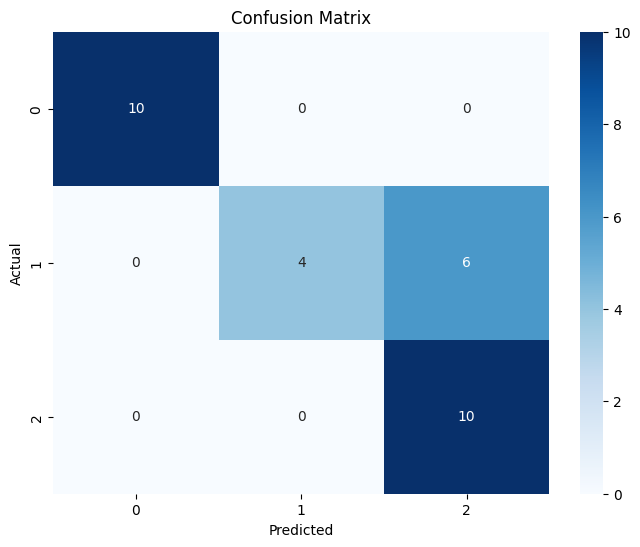

In [89]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()